In [1]:
# Jupyter notebook Python code voor Autoencode Neural Net Jeugddata Zuid Holland Zuid
# Auteur Kees van den Tempel, AI-labs BV, Tricht
# Versie 1.0
# 10-12-2022
# Dit script bepaalt de afwijkingen in de declaraties van jeugdzorg gegevens m.b.v. Isolation
# Forest en een Support Vector Machine (SVM). Het nadeel van isolation forest is dat je vooraf het aantal afwijkingen
# moet aangeven m.b.v. een contamination-getal. Isolation Forest wordt gebruikt om de Vanilla AutoEncoder en 
# de Variational AutoEncoder te testen. x_train en x_test krijgen twee nieuwe kolommen, namelijk scores en anomaly.
# anomaly is een waar 1 (=anomaly) of 0(= geen anomaly).

# Na het berekenen van de afwijkingen wordt m.b.v. een Random Forest Classifier de x_train en de x_test gebruikt om
# de anomaly waarde (berkend met Isolation Forest) nogmaals te voorspellen. Dit geeft de betrouwbaarheid van de 
# isolation forest berekening weer, maar geeft ook aan welke features belangrijk zijn en welke niet.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import datetime
from IPython.display import Image
import pickle
import json

import sklearn
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import model_selection

#%matplotlib inline

DevSet = 0.0
Testset = 0.1
Calc_Log = True
HyperparameterTuning = False
UseKFold = False
NormalizeData = False
RandomForest = True
Categorical_Limiet = 1200000000
target = 'GedeclareerdeKostenExclBtw'
CorrelatieKenmerk = 'Hoeveelheid'
DeleteColumns = False
UsePca = False

# load all data
x_train = pd.read_csv("data/IF_Declaraties_autoencoder_train.csv", decimal=",", sep=";")
x_test = pd.read_csv("data/IF_Declaraties_autoencoder_test.csv", decimal=",", sep=";")
x_train.drop(['Unnamed: 0', '__Volgnummer'], axis=1, inplace=True)
x_test.drop(['Unnamed: 0', '__Volgnummer'], axis=1, inplace=True)

print("De training dataset bevat " + str(x_train.shape) + " records")
print("De test dataset bevat " + str(x_test.shape) + " records")

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
x_train.info()

De training dataset bevat (554280, 18) records
De test dataset bevat (61587, 18) records
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554280 entries, 0 to 554279
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DeclaratieId                554280 non-null  int64  
 1   ContractStatusId            554280 non-null  int64  
 2   Periodenummer               554280 non-null  int64  
 3   GedeclareerdeTariefExclBtw  554280 non-null  float64
 4   GedeclareerdeKostenExclBtw  554280 non-null  float64
 5   GemeenteId                  554280 non-null  int64  
 6   TeamId                      554280 non-null  int64  
 7   BudgettypeId                554280 non-null  float64
 8   nProductID                  554280 non-null  float64
 9   nAanbiederID                554280 non-null  float64
 10  __ContractDuur              554280 non-null  int64  
 11  __MeanProductDecl           554280 non-nu

In [2]:
DID_train = x_train['DeclaratieId']
DID_test = x_test['DeclaratieId']

x_train.drop(['DeclaratieId'], axis=1, inplace=True)
x_test.drop(['DeclaratieId'], axis=1, inplace=True)
x_train.head(15)


,ContractStatusId,Periodenummer,GedeclareerdeTariefExclBtw,GedeclareerdeKostenExclBtw,GemeenteId,TeamId,BudgettypeId,nProductID,nAanbiederID,__ContractDuur,__MeanProductDecl,__AantalProductDecl,__MeanAanbiederDecl,__DeclaratiePeriode,__MeanProductDeclduur,__StdDevClientDeclduur,__EerdereDeclaraties
0,5800,5,103.80,25.95,4,21,305.0,22738.0,1240.0,500000000,857.183498,111285,931.723336,0,39.725237,44.384019,27491.44
1,5800,3,57.09,285.45,4,23,303.0,23267.0,1209.0,9900000000,474.671844,6237,598.977243,28,22.710277,13.346117,63097.72
2,5800,3,85.20,340.80,8,26,303.0,23599.0,1215.0,10100000000,532.884996,26505,477.664110,0,11.970307,13.889620,13159.83
3,5800,5,241.36,10.26,15,20,306.0,9999.0,2142.0,1100000000,133.816467,2035,787.616492,0,0.613759,9.416221,26752.45
4,5800,6,112.80,282.00,2,20,303.0,23592.0,1209.0,10600000000,489.176784,6387,598.977243,30,20.297949,13.660090,15251.06
5,5800,2,1022.32,1022.32,4,21,305.0,22738.0,1246.0,800000000,857.183498,111285,507.102068,242,39.725237,87.681241,3550.42
6,5800,11,173.82,1129.83,6,24,306.0,6749.0,1271.0,9900000000,325.537732,46164,1007.924744,0,0.284551,22.132513,59101.57
7,5800,2,383.09,383.09,9999,27,309.0,23594.0,2164.0,500000000,431.734828,12704,581.500330,0,15.861855,15.383272,62044.70
8,5800,12,134.00,4154.00,4,21,306.0,9999.0,2142.0,1100000000,3766.045280,3540,787.616492,0,6.041243,8.726130,54445.42
9,5800,11,173.82,10.72,4,21,306.0,6749.0,1271.0,1100000000,325.537732,46164,1007.924744,0,0.284551,9.318660,16195.96


In [ ]:
def DeleteVars(df):
    df.drop(['Unnamed: 0'], axis=1, inplace=True)

    volgnummers = [var for var in df.columns if '__' in var]
    print(volgnummers)
    df.drop(volgnummers, axis=1, inplace=True)

    #gemeenten = [var for var in df.columns if 'Gemeente' in var]
    #print(gemeenten)
    #df.drop(gemeenten, axis=1, inplace=True)

    #client = [var for var in df.columns if 'Client' in var]
    #print(client)
    #df.drop(client, axis=1, inplace=True)

    contract = [var for var in df.columns if 'ContractId' in var]
    print(contract)
    df.drop(contract, axis=1, inplace=True)

if DeleteColumns == False:
    DeleteVars(x_train)
    DeleteVars(x_test)

In [8]:
# https://medium.com/analytics-vidhya/evaluation-metrics-for-classification-problems-with-implementation-in-python-a20193b4f2c3
def DisplayMetrics(rf, y_test, y_pred, makeplots, titel):
    print("\n" + titel)
    print("Accuracy (goed-voorspeld/totaal) (niet voor unbalanced dataset): " + str(accuracy_score(y_test, y_pred).round(3)))
    print(f"Precision Score is (TP/TP+FP): {precision_score(y_test, y_pred).round(3)}")
    print(f"Recall Score is (TP/TP+FN): {recall_score(y_test, y_pred).round(3)}")
    print(f"F1 Score is (2*P*R/P+R): {f1_score(y_test, y_pred).round(3)}")    
    print("Random Forests roc-auc (bin class): {}".format(roc_auc_score(y_test, y_pred).round(3)))

    if makeplots == True:
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        
        # confusion_matrix function a matrix containing the summary of predictions
        cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
        disp.plot()
        plt.show()

        # Plotting the ROC
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    # Making the Confusion Matrix
    # print(pd.crosstab(y_test, y_pred, rownames=['Actuele zorgkosten'], colnames=['Voorspelde zorgkosten']))
    print (metrics.classification_report(y_pred, y_test))


In [ ]:
#scale predictor variables
from sklearn.decomposition import PCA

if UsePca == True:
    pca=PCA()
    pca.fit(x_train)
    x_train = pd.DataFrame(pca.transform(x_train))
    x_test = pd.DataFrame(pca.transform(x_test))

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM

sv = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.03).fit(x_train)
#sv = svm.SVC(kernel='rbf', gamma=0.05, C=8).fit(x_train, y_train)

# Predicting the Test set results
x_train["anomaly"] = sv.predict(x_train)
x_test["anomaly"] = sv.predict(x_test)

print("\nSupport Vector Machine classifier getrained met " + str(np.shape(x_train)[0]) + " records")
print("Support Vector Machine classifier getest met " + str(np.shape(x_test)[0]) + " records")

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554280 entries, 0 to 554279
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DeclaratieId                554280 non-null  int64  
 1   ContractStatusId            554280 non-null  int64  
 2   Periodenummer               554280 non-null  int64  
 3   GedeclareerdeTariefExclBtw  554280 non-null  float64
 4   GedeclareerdeKostenExclBtw  554280 non-null  float64
 5   GemeenteId                  554280 non-null  int64  
 6   TeamId                      554280 non-null  int64  
 7   BudgettypeId                554280 non-null  float64
 8   nProductID                  554280 non-null  float64
 9   nAanbiederID                554280 non-null  float64
 10  __ContractDuur              554280 non-null  int64  
 11  __MeanProductDecl           554280 non-null  float64
 12  __AantalProductDecl         554280 non-null  int64  
 13  __MeanAanbiede

In [4]:
# https://medium.com/@shreyash0023/anomaly-detection-on-a-categorical-and-continuous-dataset-d5af7aa287d2
# https://www.rdocumentation.org/packages/isotree/versions/0.5.17/topics/predict.isolation_forest
# LEZEN !!
# SUGGESTIE: het aantal features verkleinen, geen feature engineering en tegen elkaar plotten

def Anomaly_metrics(df, pred, model):
    df['scores'] = model.decision_function(df.values)
    df['anomaly'] = pred

    outliers = df.loc[df['anomaly']==-1]
    outlier_index = list(outliers.index)

    # Find the number of anomalies and normal points here points classified -1 are anomalous
    # print(df['scores'])
    # print(outlier_index)
    anomaly_count = len(pred[pred==-1])
    print(str(anomaly_count) + " anomalies found in dataset from " + str(pred.shape[0]) + " records")
    
    accuracy = 100 * anomaly_count/int(pred.shape[0])
    print("Percentage of anomalies :", accuracy)
    return df

df_train = Anomaly_metrics(x_train, sv.predict(x_train.values), sv)
x_pred = sv.predict(x_test.values)
df_test = Anomaly_metrics(x_test, x_pred, sv)

df_train = pd.concat([DID_train, df_train], axis=1)
df_test = pd.concat([DID_test, df_test], axis=1)

print("Anomalie records van de testset:")
print(df_test[df_test['anomaly']==-1]['DeclaratieId'])

2772 anomalies found in dataset from 554280 records
Percentage of anomalies : 0.5001082485386448
333 anomalies found in dataset from 61587 records
Percentage of anomalies : 0.5406985240391641
Anomalie records van de testset:
286      2152439
373      2152336
378      1836486
601      3470662
650      1902165
          ...   
61348    2444982
61428    2154306
61434    1599158
61511    2712997
61584    1530846
Name: DeclaratieId, Length: 333, dtype: int64


In [6]:
dfs = df_test[df_test["anomaly"]==-1]
print(dfs.groupby("nProductID")["nProductID"].count().sort_values(ascending=False).head())
print(df_test[df_test["anomaly"]==-1][["DeclaratieId", "nAanbiederID", "nProductID", "GedeclareerdeKostenExclBtw"]].head(20))

[ 1 -1]
nProductID
9999.0     267
22738.0     65
22813.0      1
Name: nProductID, dtype: int64
      DeclaratieId  nAanbiederID  nProductID  GedeclareerdeKostenExclBtw
286        2152439        1281.0      9999.0                    68192.95
373        2152336        9999.0      9999.0                    11097.00
378        1836486        1281.0      9999.0                   117514.11
601        3470662        1025.0      9999.0                    12361.25
650        1902165        1281.0      9999.0                    12477.32
742        1920726        1693.0      9999.0                     6998.74
926        2335649        9999.0      9999.0                     7024.35
939        1522353        9999.0     22738.0                    16670.85
1064       1920861        1693.0      9999.0                      311.29
1093       3503512        9999.0      9999.0                    12862.52
1161       2621316        9999.0      9999.0                     7110.91
1606       2010503        118

In [7]:
if RandomForest == True:
    xrf_train = df_train.copy()
    xrf_test = df_test.copy()
    yrf_train = df_train["anomaly"]
    yrf_test = df_test["anomaly"]
    xrf_train.drop(columns=["anomaly", "scores"], axis=0, inplace=True)
    xrf_test.drop(columns=["anomaly", "scores"], axis=0, inplace=True)

    print(str(type(x_train)) + ': xrf_train Shape:', x_train.shape)
    print(str(type(x_test)) + ': xrf_test Shape:', x_test.shape)
    print(xrf_train.info())

<class 'pandas.core.frame.DataFrame'>: xrf_train Shape: (554280, 19)
<class 'pandas.core.frame.DataFrame'>: xrf_test Shape: (61587, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554280 entries, 0 to 554279
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   DeclaratieId                554280 non-null  int64  
 1   ContractStatusId            554280 non-null  int64  
 2   Periodenummer               554280 non-null  int64  
 3   GedeclareerdeTariefExclBtw  554280 non-null  float64
 4   GedeclareerdeKostenExclBtw  554280 non-null  float64
 5   GemeenteId                  554280 non-null  int64  
 6   TeamId                      554280 non-null  int64  
 7   BudgettypeId                554280 non-null  float64
 8   nProductID                  554280 non-null  float64
 9   nAanbiederID                554280 non-null  float64
 10  __ContractDuur              554280 non-null  int64  

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

if RandomForest == True:
    rf = RandomForestClassifier(n_estimators = 250, max_depth=15, min_samples_split=10, max_features=15, bootstrap=True, min_samples_leaf=1, random_state = 42)

    # Train the model on training data
    rf.fit(xrf_train, yrf_train);

    print("\nRandomForest regressor getrained met " + str(np.shape(xrf_train)[0]) + " records")
    print("RandomForest regressor getest met " + str(np.shape(xrf_test)[0]) + " records\n")
    
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(xrf_train.columns.values, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    print("\nBELANGRIJKE VARIABELEN")
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


RandomForest regressor getrained met 554280 records
RandomForest regressor getest met 61587 records


BELANGRIJKE VARIABELEN
Variable: __MeanProductDecl    Importance: 0.61
Variable: GedeclareerdeTariefExclBtw Importance: 0.09
Variable: __MeanProductDeclduur Importance: 0.06
Variable: GedeclareerdeKostenExclBtw Importance: 0.05
Variable: __StdDevClientDeclduur Importance: 0.03
Variable: __EerdereDeclaraties Importance: 0.03
Variable: GemeenteId           Importance: 0.02
Variable: BudgettypeId         Importance: 0.02
Variable: __MeanAanbiederDecl  Importance: 0.02
Variable: __DeclaratiePeriode  Importance: 0.02
Variable: DeclaratieId         Importance: 0.01
Variable: TeamId               Importance: 0.01
Variable: nAanbiederID         Importance: 0.01
Variable: __AantalProductDecl  Importance: 0.01
Variable: ContractStatusId     Importance: 0.0
Variable: Periodenummer        Importance: 0.0
Variable: nProductID           Importance: 0.0
Variable: __ContractDuur       Importance: 0.0


RESULTATEN TESTSET
Accuracy (goed-voorspeld/totaal) (niet voor unbalanced dataset): 0.999
Precision Score is (TP/TP+FP): 1.0
Recall Score is (TP/TP+FN): 1.0
F1 Score is (2*P*R/P+R): 1.0
Random Forests roc-auc (bin class): 0.982


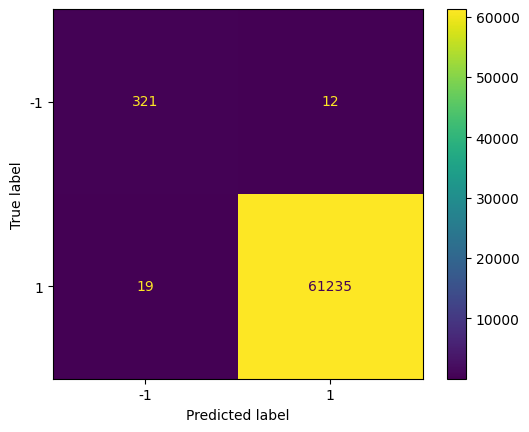

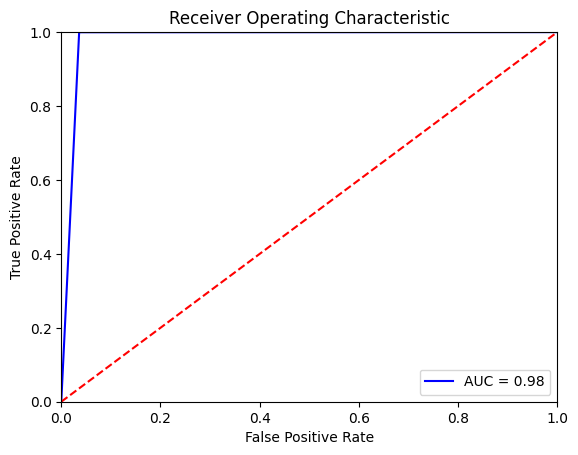

In [10]:
if RandomForest == True:
    DisplayMetrics(rf, yrf_test, rf.predict(xrf_test), True, "RESULTATEN TESTSET")



RESULTATEN TRAIN SET
Accuracy (goed-voorspeld/totaal) (niet voor unbalanced dataset): 1.0
Precision Score is (TP/TP+FP): 1.0
Recall Score is (TP/TP+FN): 1.0
F1 Score is (2*P*R/P+R): 1.0
Random Forests roc-auc (bin class): 0.99


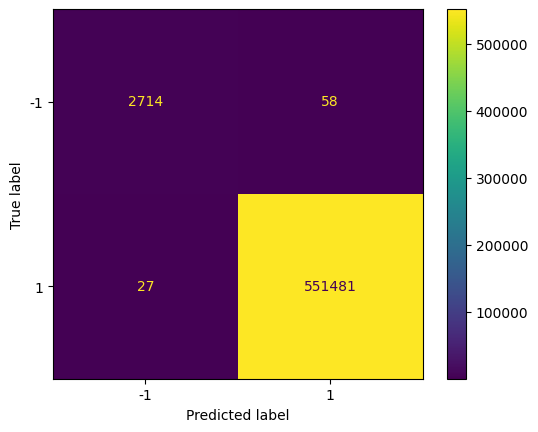

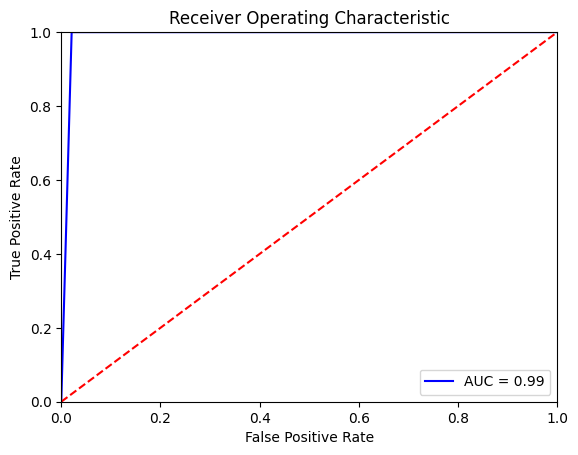

In [11]:
if RandomForest == True:
    DisplayMetrics(rf, yrf_train, rf.predict(xrf_train), True, "RESULTATEN TRAIN SET")

In [12]:
# Hyper parameter tuning met CV grid search
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

if (HyperparameterTuning == True) and (RandomForest == True):
    
    model = IsolationForest(random_state=47)

    param_grid = {'n_estimators': [100, 500], 
                  'max_samples': [10], 
                  'contamination': ['auto', 0.01, 0.02], 
                  'max_features': [10, 15], 
                  'bootstrap': [True], 
                  'n_jobs': [-1]}

    print("\nDit zijn de parameters waarmee getest gaan worden")
    print(param_grid)
    print("\n")

    grid_search = model_selection.GridSearchCV(model, 
                                               param_grid,
                                               scoring="neg_mean_squared_error", 
                                               refit=True,
                                               cv=10, 
                                               return_train_score=True)
    grid_search.fit(x_train, x_train)

    best_model = grid_search.fit(x_train, x_train)
    print('Optimum parameters', best_model.best_params_)
    print("\n")


In [13]:
if (UseKFold == True) and (RandomForest == True):
    df = np.array(RFscores)
    print('KFold R2 Score:', round(df[:,1].mean()), '%.')
    